In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Thu Jun 23 23:48:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   53C    P2    78W / 260W |   4535MiB / 11019MiB |     25%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 26%   

# LDA

## 2014 brief paragraph

In [3]:
file_cn = open("../LDA/segment/data/cn_file_brief_paragraph_2014.txt", "r")
cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(cn_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(7466 unique tokens: ['\n', '一种', '二元', '优良', '加工性']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in cn_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.464491,1744.966279
1,3,-7.439127,1701.264223
2,4,-7.423100,1674.215722
3,5,-7.390144,1619.939679
4,6,-7.392826,1624.289726
5,7,-7.381023,1605.231540
6,8,-7.366243,1581.680134
7,9,-7.355111,1564.170043
8,10,-7.351388,1558.358773
9,11,-7.353261,1561.279152


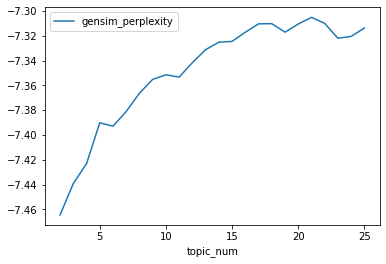

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.464491,1744.966279
1,3,-7.439127,1701.264223
2,4,-7.423100,1674.215722
3,5,-7.390144,1619.939679
4,6,-7.392826,1624.289726
5,7,-7.381023,1605.231540
6,8,-7.366243,1581.680134
7,9,-7.355111,1564.170043
8,10,-7.351388,1558.358773
9,11,-7.353261,1561.279152


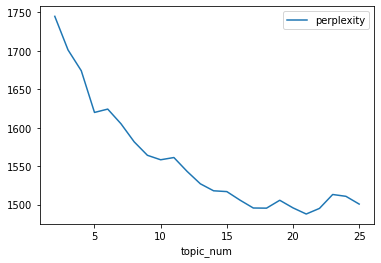

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_cn_brief_paragraph_2014.csv", index=False)

## priority description sentence

In [11]:
# file_cn = open("../MUSE-main/data/cn_file_desc_p_s_2500.txt", "r")
# cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(cn_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in cn_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_cn_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

8

In [23]:
topics_cn = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_cn.append(c.index(max(c)))

In [24]:
topics_cn

[8,
 9,
 1,
 4,
 7,
 1,
 9,
 13,
 14,
 5,
 1,
 2,
 9,
 20,
 1,
 7,
 9,
 18,
 4,
 13,
 7,
 3,
 4,
 4,
 8,
 7,
 20,
 8,
 4,
 10,
 9,
 3,
 20,
 18,
 12,
 5,
 17,
 10,
 2,
 15,
 4,
 1,
 4,
 17,
 16,
 10,
 4,
 14,
 1,
 1,
 15,
 3,
 8,
 7,
 7,
 9,
 7,
 8,
 5,
 19,
 7,
 1,
 3,
 5,
 5,
 8,
 18,
 4,
 1,
 15,
 3,
 8,
 14,
 14,
 18,
 14,
 1,
 1,
 4,
 14,
 5,
 3,
 8,
 1,
 8,
 5,
 1,
 18,
 2,
 7,
 5,
 18,
 12,
 9,
 17,
 9,
 12,
 5,
 12,
 10,
 5,
 5,
 7,
 9,
 1,
 14,
 12,
 9,
 17,
 7,
 15,
 3,
 8,
 2,
 5,
 1,
 15,
 7,
 13,
 7,
 5,
 2,
 3,
 1,
 12,
 9,
 14,
 12,
 7,
 19,
 4,
 7,
 2,
 13,
 11,
 14,
 13,
 5,
 15,
 7,
 17,
 15,
 1,
 2,
 19,
 15,
 9,
 2,
 16,
 3,
 5,
 1,
 14,
 2,
 3,
 5,
 7,
 2,
 7,
 7,
 3,
 5,
 11,
 20,
 4,
 11,
 14,
 2,
 7,
 17,
 9,
 18,
 16,
 4,
 2,
 0,
 12,
 12,
 6,
 20,
 15,
 1,
 6,
 7,
 5,
 7,
 3,
 11,
 5,
 9,
 16,
 7,
 9,
 5,
 5,
 18,
 4,
 19,
 7,
 1,
 12,
 3,
 9,
 16,
 16,
 18,
 18,
 0,
 7,
 12,
 9,
 5,
 14,
 19,
 6,
 7,
 14,
 0,
 12,
 2,
 18,
 5,
 20,
 14,
 5,
 18,
 4,
 0,
 5,
 

In [25]:
print(len(topics_cn))
print(len(cn_desc))

845
845


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2014 = db.rm_patent_us_2014
    db_rm_cn_2014 = db.rm_patent_cn_2014
    # db_rm_de_2014 = db.rm_patent_de_2014
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_cn_desc = p_db_cn.find({}, {"patentNumber":1, "brief": 1})
data_cn_desc = db_rm_cn_2014.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_cn_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_cn

,id,patentNumber,company,brief
0,61fd53e7f4d57576a5021f0d,CN105264001B,[Clariant International Ltd],None
1,61fd54bdf4d57576a5021f1f,CN104937034A,[Asahi Kasei Corp],本发明的目的在于提供白度、耐回流焊接性、耐热变色性、耐光变色性以及挤出加工性优良的聚酰胺组合...
2,61fd559cf4d57576a5021f31,CN105764918A,[University of Edinburgh],本发明提供了重组蛋白质，其能够与补体因子H(CFH)结合，并因此与未结合CFH相比，诱导已结...
3,61fd56bcf4d57576a5021f4d,CN105849197B,[EMS Patent AG],描述了一种热塑性的、阻燃性的塑料模塑料，所述塑料膜塑料具有改进的机械特性和更好的表面特性、尤...
4,61fd5704f4d57576a5021f53,CN104394898B,"[German kaidnuo Co., Ltd.]",本发明涉及用活性剂和虫胶碱盐、优选虫胶铵盐涂覆的球囊导管。此外本发明涉及用药理学活性剂和虫胶...
...,...,...,...,...
840,61fe6d8df4d57576a5024e19,CN203871606U,[Zhuhai Youte Iot Technology Co Ltd],本实用新型公开了一种单插通电联网式个人计算机及个人计算机组网架构。个人计算机包括计算机主机、...
841,61fe6d92f4d57576a5024e1f,CN104017931A,[Tangshan Guofeng Iron and Steel Co Ltd],本发明提供一种干法除尘转炉冶炼低碳钢终点留渣操作法。本发明留渣操作法，可以在保证电除法转炉不...
842,61fe6d92f4d57576a5024e21,CN103833058A,[Changzhou Youbang Water-purging Material Co Ltd],本发明公开了一种提高PAC压滤性能的方法，该方法通过调控原料配比和生产工艺来改进PAC的压滤...
843,61fe6d9af4d57576a5024e27,CN105527589B,[SAGA GROUP Ltd],一种磁力计，包括一个悬浮的质量块，一组Y方向位移侦测电极，一组Z方向位移侦测电极，以及一电流...


In [30]:
print(len(df_cn))
print(len(cn_desc))

845
845


In [31]:
df_cn["topic"]=topics_cn

In [32]:
df_cn

,id,patentNumber,company,brief,topic
0,61fd53e7f4d57576a5021f0d,CN105264001B,[Clariant International Ltd],None,8
1,61fd54bdf4d57576a5021f1f,CN104937034A,[Asahi Kasei Corp],本发明的目的在于提供白度、耐回流焊接性、耐热变色性、耐光变色性以及挤出加工性优良的聚酰胺组合...,9
2,61fd559cf4d57576a5021f31,CN105764918A,[University of Edinburgh],本发明提供了重组蛋白质，其能够与补体因子H(CFH)结合，并因此与未结合CFH相比，诱导已结...,1
3,61fd56bcf4d57576a5021f4d,CN105849197B,[EMS Patent AG],描述了一种热塑性的、阻燃性的塑料模塑料，所述塑料膜塑料具有改进的机械特性和更好的表面特性、尤...,4
4,61fd5704f4d57576a5021f53,CN104394898B,"[German kaidnuo Co., Ltd.]",本发明涉及用活性剂和虫胶碱盐、优选虫胶铵盐涂覆的球囊导管。此外本发明涉及用药理学活性剂和虫胶...,7
...,...,...,...,...,...
840,61fe6d8df4d57576a5024e19,CN203871606U,[Zhuhai Youte Iot Technology Co Ltd],本实用新型公开了一种单插通电联网式个人计算机及个人计算机组网架构。个人计算机包括计算机主机、...,3
841,61fe6d92f4d57576a5024e1f,CN104017931A,[Tangshan Guofeng Iron and Steel Co Ltd],本发明提供一种干法除尘转炉冶炼低碳钢终点留渣操作法。本发明留渣操作法，可以在保证电除法转炉不...,15
842,61fe6d92f4d57576a5024e21,CN103833058A,[Changzhou Youbang Water-purging Material Co Ltd],本发明公开了一种提高PAC压滤性能的方法，该方法通过调控原料配比和生产工艺来改进PAC的压滤...,1
843,61fe6d9af4d57576a5024e27,CN105527589B,[SAGA GROUP Ltd],一种磁力计，包括一个悬浮的质量块，一组Y方向位移侦测电极，一组Z方向位移侦测电极，以及一电流...,10


In [33]:
df_cn2 = df_cn.explode('company')
df_cn2

,id,patentNumber,company,brief,topic
0,61fd53e7f4d57576a5021f0d,CN105264001B,Clariant International Ltd,None,8
1,61fd54bdf4d57576a5021f1f,CN104937034A,Asahi Kasei Corp,本发明的目的在于提供白度、耐回流焊接性、耐热变色性、耐光变色性以及挤出加工性优良的聚酰胺组合...,9
2,61fd559cf4d57576a5021f31,CN105764918A,University of Edinburgh,本发明提供了重组蛋白质，其能够与补体因子H(CFH)结合，并因此与未结合CFH相比，诱导已结...,1
3,61fd56bcf4d57576a5021f4d,CN105849197B,EMS Patent AG,描述了一种热塑性的、阻燃性的塑料模塑料，所述塑料膜塑料具有改进的机械特性和更好的表面特性、尤...,4
4,61fd5704f4d57576a5021f53,CN104394898B,"German kaidnuo Co., Ltd.",本发明涉及用活性剂和虫胶碱盐、优选虫胶铵盐涂覆的球囊导管。此外本发明涉及用药理学活性剂和虫胶...,7
...,...,...,...,...,...
840,61fe6d8df4d57576a5024e19,CN203871606U,Zhuhai Youte Iot Technology Co Ltd,本实用新型公开了一种单插通电联网式个人计算机及个人计算机组网架构。个人计算机包括计算机主机、...,3
841,61fe6d92f4d57576a5024e1f,CN104017931A,Tangshan Guofeng Iron and Steel Co Ltd,本发明提供一种干法除尘转炉冶炼低碳钢终点留渣操作法。本发明留渣操作法，可以在保证电除法转炉不...,15
842,61fe6d92f4d57576a5024e21,CN103833058A,Changzhou Youbang Water-purging Material Co Ltd,本发明公开了一种提高PAC压滤性能的方法，该方法通过调控原料配比和生产工艺来改进PAC的压滤...,1
843,61fe6d9af4d57576a5024e27,CN105527589B,SAGA GROUP Ltd,一种磁力计，包括一个悬浮的质量块，一组Y方向位移侦测电极，一组Z方向位移侦测电极，以及一电流...,10


In [34]:
# 排名前16的公司
c_ls = list(df_cn2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Nanjing IoT Sensor Technology Co Ltd',
 'Jiangsu IoT Research and Development Center',
 'Suzhou Hickman IOT Technology Co. Ltd.',
 'Zhuhai Youte Iot Technology Co Ltd',
 'ZTE Intelligent IoT Technology Co Ltd',
 'GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd',
 'GUANGZHOU WULIANJIA INFORMATION TECHNOLOGY Co Ltd',
 'Datang Mobile Communications Equipment Co Ltd',
 'Jiangsu CAS IGBT Technology Co Ltd',
 'Huawei Technologies Co Ltd',
 'BEIJING GOLDENET IOT TECHNOLOGY Co Ltd',
 'Institute of Microelectronics of CAS',
 'ANHUI YONGDA IOT Co Ltd',
 'China core Microelectronics Technology Chengdu Co.,Ltd.',
 'JIANGSU ZHONGKE YILIAN COMMUNICATION TECHNOLOGY CO., LTD.',
 'Suzhou Wa Wu Internet Of Things Science And Technology Ltd']

### 轉成company-topic 的總數表格

In [35]:
df_cn_count = df_cn2.groupby(["company","topic"],as_index=False).size()
df_cn_count

,company,topic,size
0,3M innovation intellectual property Co.,16,1
1,ANHUI BAIBAITONG INTERNET OF THINGS TECHNOLOGY...,4,1
2,ANHUI BAIBAITONG INTERNET OF THINGS TECHNOLOGY...,10,1
3,ANHUI LIYUAN CNC BLADE MOLD MANUFACTURING Co Ltd,7,1
4,ANHUI YONGDA IOT Co Ltd,3,2
...,...,...,...
664,Zhuhai Youte Iot Technology Co Ltd,12,1
665,Zhuhai Youte Iot Technology Co Ltd,13,1
666,Zhuhai Youte Iot Technology Co Ltd,14,1
667,Zhuhai yote IOT Technology Co. Ltd.,20,1


In [36]:
# 轉成company-topic 的總數表格
table_cn = df_cn_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_cn = table_cn.droplevel(level=0, axis=1)
table_cn = table_cn.rename(columns={'':'company'})

In [37]:
table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,3M innovation intellectual property Co.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,ANHUI BAIBAITONG INTERNET OF THINGS TECHNOLOGY...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ANHUI LIYUAN CNC BLADE MOLD MANUFACTURING Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ANHUI YONGDA IOT Co Ltd,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
4,ATI Properties LLC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,Zhuhai TongZhou Hongxing smart IOT Technology ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,Zhuhai Unicook Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
434,Zhuhai Youte Iot Technology Co Ltd,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
435,Zhuhai yote IOT Technology Co. Ltd.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [38]:
final_table_cn = table_cn[table_cn.company.isin(c_ls)]
final_table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
3,ANHUI YONGDA IOT Co Ltd,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
17,BEIJING GOLDENET IOT TECHNOLOGY Co Ltd,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
68,China core Microelectronics Technology Chengdu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
79,Datang Mobile Communications Equipment Co Ltd,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0
96,GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY Co Ltd,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
109,GUANGZHOU WULIANJIA INFORMATION TECHNOLOGY Co Ltd,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
142,Huawei Technologies Co Ltd,0.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
160,Institute of Microelectronics of CAS,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
177,JIANGSU ZHONGKE YILIAN COMMUNICATION TECHNOLOG...,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
188,Jiangsu CAS IGBT Technology Co Ltd,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


In [39]:
final_table_cn.shape

(16, 22)

In [40]:
table_cn.to_csv('company_lda_brief_cn_2014.csv',index=0)